## Standard Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets,transforms,models

Filtering warnings to ignore useless warnings

In [3]:
import os
import warnings
warnings.filterwarnings('ignore')

## Applying transformation to the Images

In [4]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.458,0.456,0.406],std = [0.229,0.224,0.225])
])

Using means (0.458,0.456,0.406) and standard deviations (0.229,0.224,0.225) respectively for each color channel<br>
Why ?<br>
From over 10,000 of images these values are found by Researchers at PyTorch Team<br>
[Here is a discussion](https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/22)

In [5]:
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.458,0.456,0.406],std = [0.229,0.224,0.225])
])

## Loading data

In [6]:
root = "./CATS_DOGS/"

train_data = datasets.ImageFolder(root = os.path.join(root,'train'),transform=train_transform)
test_data = datasets.ImageFolder(root = os.path.join(root,'test'),transform=test_transform)

In [7]:
train_loader = DataLoader(train_data,shuffle = True,batch_size = 10,pin_memory=True)
test_loader = DataLoader(test_data,batch_size = 10,pin_memory=True)

In [8]:
class_names = train_data.classes

In [9]:
for image,label in train_loader:
    break

In [10]:
image.shape

torch.Size([10, 3, 224, 224])

## Model Definition and Instantiation

In [11]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(54*54*16,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,2)
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = X.view(-1,54*54*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X,dim = 1)

In [12]:
model = CNNModel()
model = model.cuda()

## Setting up Loss Function and Optmizer

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [14]:
import time
import math
start = time.time()
epochs = 10
train_losses = []
train_correct = []
test_losses = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    for b,(X_train,Y_train) in enumerate(train_loader):
        b+=1
        X_train = X_train.cuda()
        Y_train = Y_train.cuda()
        Y_pred = model(X_train)
        loss = criterion(Y_pred,Y_train)
        predictions = torch.max(Y_pred.data,1)[1]
        trn_corr+= (predictions == Y_train).sum()
        if b%125==0:
            print(f'Epoch {i+1} batch:{b} [{b*10}/{18750}] loss:{loss.item():.2f} accuracy:{(trn_corr.item()*100)/(10*b):.2f}')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_losses.append(loss)
    train_correct.append(trn_corr)
    with torch.no_grad():
        for(X_test,Y_test) in test_loader:
            X_test = X_test.cuda()
            Y_test = Y_test.cuda()
            Y_val = model(X_test)
            predictions = torch.max(Y_val.data,1)[1]
            tst_corr+= (predictions == Y_test).sum()
        loss = criterion(Y_val,Y_test)
        test_losses.append(loss)
        test_correct.append(tst_corr)
end = time.time()
print(f'Train Duration : {(end-start)//60} minutes {math.ceil((end-start)%60)} seconds')

Epoch 1 batch:125 [1250/18750] loss:0.66 accuracy:54.96
Epoch 1 batch:250 [2500/18750] loss:0.72 accuracy:57.52
Epoch 1 batch:375 [3750/18750] loss:0.67 accuracy:59.84
Epoch 1 batch:500 [5000/18750] loss:0.62 accuracy:59.54
Epoch 1 batch:625 [6250/18750] loss:0.77 accuracy:60.32
Epoch 1 batch:750 [7500/18750] loss:0.58 accuracy:61.65
Epoch 1 batch:875 [8750/18750] loss:0.62 accuracy:62.37
Epoch 1 batch:1000 [10000/18750] loss:0.63 accuracy:63.00
Epoch 1 batch:1125 [11250/18750] loss:0.56 accuracy:63.82
Epoch 1 batch:1250 [12500/18750] loss:0.60 accuracy:64.46
Epoch 1 batch:1375 [13750/18750] loss:0.57 accuracy:65.02
Epoch 1 batch:1500 [15000/18750] loss:0.46 accuracy:65.41
Epoch 1 batch:1625 [16250/18750] loss:0.53 accuracy:65.56
Epoch 1 batch:1750 [17500/18750] loss:1.21 accuracy:66.13
Epoch 1 batch:1875 [18750/18750] loss:0.29 accuracy:66.57
Epoch 2 batch:125 [1250/18750] loss:0.52 accuracy:74.08
Epoch 2 batch:250 [2500/18750] loss:0.39 accuracy:74.28
Epoch 2 batch:375 [3750/18750] l

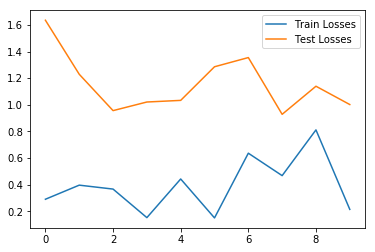

In [15]:
plt.plot(train_losses,label = 'Train Losses')
plt.plot(test_losses,label = 'Test Losses')
plt.legend()

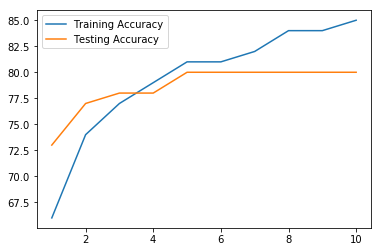

In [18]:
plt.plot([i for i in range(1,11)],[100*i/18743 for i in train_correct],label = 'Training Accuracy')
plt.plot([i for i in range(1,11)],[100*i/6251 for i in test_correct],label = 'Testing Accuracy')
plt.legend()

## Saving Model

In [19]:
torch.save(model.state_dict(),"./model.pt")